# <b>DarkVec: Automatic Analysis of Darknet Trafficwith Word Embeddings</b>
## <b>4) Unsupervised Approach: Clustering</b>  

___

## <b>Table of Content</b> <a id="toc_"></a>

* [Heuristic for k of k-NN Graph](#kofknnG)  
* [Clustering Algorithms Comparison](#algos)  
    * [Hierarchical Clustering](#hierarchical)  
    * [k-Means](#kmeans)  
    * [Spectral Clustering](#spectral)  
    * [k-NN Graph](#kmeknnGans)  
* [Louvain on k-NN Graph](#results)

Notebook description

___
***Note:*** All the code and data we provide are the ones included in the paper. To speed up the notebook execution, by default we trim the files when reading them. Comments on how to run on complete files are provided in the notebook. Note that running the notebook with the complete dataset requires *a PC with significant amount of memory*. 

***Note:*** Be aware that these script require a large amount of time for training all models tested in the paper.

In [6]:
DEMONSTRATIVE = False

In [1]:
from config import *
from src.word2vec import Word2Vec
from src.preprocess import load_raw_data, filter_data
from src.knnClassifier import *
from src.callbacks import *
from src.utils import *
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

from sklearn import preprocessing

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import fastplot
from cycler import cycler
from src.knnGraph import *
plt.rcParams["font.family"] = "serif"

cc = (cycler('color',['k', 'r', 'b', 'g', 'y', 'm', 'c'])+
      cycler('linestyle',['-', '--', '-.', ':', '-', '--', '-.']))

___
### <b>Prerequisites</b> <a name="trainwindow"></a>



In [3]:
# Load last day of traffic
raw_data = load_raw_data('20210331')
filtered = filter_data(raw_data, '20210331')

print(filtered.shape)
filtered.head(3)

(3403919, 6)


,ts,ip,port,proto,pck_len,pp
ts,,,,,,
2021-03-30 22:29:08.691001,2021-03-30 22:29:08.691001,201.166.132.114,1433,tcp,66,1433/tcp
2021-03-30 22:29:08.691010,2021-03-30 22:29:08.691010,201.166.132.114,1433,tcp,66,1433/tcp
2021-03-30 22:29:08.811067,2021-03-30 22:29:08.811067,172.245.10.231,3699,tcp,60,3699/tcp


In [4]:
# Load the ground truth
gt = pd.read_csv(GT).drop(columns=['Unnamed: 0'])
ips = filtered.ip.unique()
# Get the lookup dataframe to retrieve
# the ground truth class of the last day senders
lookup = pd.DataFrame(ips, columns=['ip'])\
           .merge(gt, on='ip', how='left')\
           .fillna('unknown').replace({ 'criminalip':'unknown', 
                'adscore':'unknown', 'quadmetrics':'unknown', 
                'esrg_stanford':'unknown', 'netscout':'unknown'})

print(lookup.shape)
lookup.head(3)

(22399, 2)


,ip,class
0,201.166.132.114,unknown
1,172.245.10.231,unknown
2,119.237.180.88,unknown


In [5]:
model_path_name = f'word2vec_auto_c5_e200'
w2v = Word2Vec(mname=f'{MODELS}/word2vec/{model_path_name}')
w2v.load_model()
embeddings = w2v.get_embeddings(ips, lookup)

print(embeddings.shape)
embeddings.head(3)

(22399, 201)


,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,class
ip,,,,,,,,,,,,,,,,,,,,,
201.166.132.114,-0.311996,-0.151880,-0.126155,-0.072640,-0.178640,0.024080,-0.022133,0.057160,-0.323721,0.022568,...,0.283371,0.126785,0.275466,0.114976,0.073976,-0.138251,0.262670,-0.148449,-0.197116,unknown
172.245.10.231,-1.256613,-1.317889,-0.910986,-0.773604,-1.041731,0.157510,-0.035242,-0.574435,-0.953921,-0.234043,...,0.120722,0.061658,0.289806,0.052150,0.272534,0.037336,0.426259,-0.294904,0.005054,unknown
119.237.180.88,-0.090121,-0.085896,0.007295,-0.115396,-0.096167,0.018933,-0.014268,0.004455,-0.023784,0.002346,...,0.032283,0.021382,0.159330,0.020799,0.031832,-0.078330,0.073449,0.004153,-0.060807,unknown


___
### <b>Heuristic for k of k-NN Graph</b> <a name="kofknnG"></a>



In [7]:
mods_linear, ncs_linear = ([], [])
if not DEMONSTRATIVE: ks = range(1,15)
else: ks = range(1,3)
for kk in ks:
    print(f'Running k: {kk}')
    if not DEMONSTRATIVE:
        knn = KnnGraph(exp_id=f'graph_heuristic', day='20210331', graph_gen=True, k=kk, 
                     embeddings=embeddings.drop(columns=['class']), ips=embeddings.index, 
                     labels=embeddings['class'].values)
    else:
        knn = KnnGraph(exp_id=f'graph_heuristic', day='20210331', graph_gen=True, k=kk, 
                     embeddings=embeddings.iloc[:500].drop(columns=['class']), ips=embeddings.iloc[:500].index, 
                     labels=embeddings.iloc[:500]['class'].values)
    knn.fit_predict()
    mods_linear.append(knn.mod)
    ncs_linear.append(knn.nc)
if not DEMONSTRATIVE:
    with open(f'{DATASETS}/knngraph_linear.json', 'w') as file:
        file.write(json.dumps({'ncs':ncs_linear, 'mods':mods_linear}))
print(f'Number of clusters for the first 2 tested k: {ncs_linear}')
print(f'Modularity of clusters for the first 2 tested k: {mods_linear}')

Running k: 1
Running k: 2
Number of clusters for the first 2 tested k: [98, 30]
Modularity of clusters for the first 2 tested k: [0.9817961218081638, 0.9152939197372963]


<Figure size 640x480 with 0 Axes>

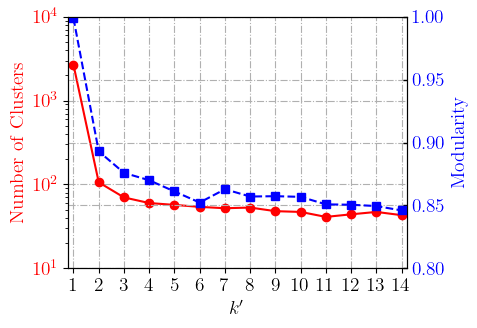

In [8]:
with open(f'{DATASETS}/knngraph_linear.json', 'r') as file:
    obj = json.loads(file.read())
ncs = obj['ncs']
mods = obj['mods']

%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: plotKnnGraphHeuristic(plt, ncs, mods),
                      figsize=(5, 3.5), fontsize=14, style='latex')
if not DEMONSTRATIVE:
    plot.savefig('reports/figures/Gheuristic.pdf')
plot.show()

___
### <b>Clustering Algorithms Comparison</b> <a name="algos"></a>



___
#### <b>k-NN Graph</b> <a name="knnG"></a>



In [ ]:
if not DEMONSTRATIVE:
    knn = KnnGraph(exp_id=f'knnGraph', day='20210331', graph_gen=True, k=3, 
                     embeddings=embeddings.drop(columns=['class']), ips=embeddings.index, 
                     labels=embeddings['class'].values)
    knn.fit_predict()#f'{GRAPHS}/knnGraph')
else:
    knn = KnnGraph(exp_id=f'knnGraph', day='20210331', graph_gen=True, k=3, 
                     embeddings=embeddings.iloc[:500].drop(columns=['class']), ips=embeddings.iloc[:500].index, 
                     labels=embeddings.iloc[:500]['class'].values)
    knn.fit_predict()
mod = knn.mod
n_clusters = knn.nc
knn_ecdf = get_sh_clustering(knn, embeddings)

___
#### <b>k-Means</b> <a name="kmeans"></a>



In [ ]:
if not DEMONSTRATIVE:
    X = embeddings.drop(columns=['class'])
else:
    X = embeddings.iloc[:500].drop(columns=['class'])
kmeans = KMeans(n_clusters=n_clusters, random_state=15)
ypred = kmeans.fit_predict(preprocessing.normalize(X))
_kmean = {'clusters':{k:v for k,v in zip(embeddings.index, ypred)}}
kmeans_ecdf = get_sh_clustering(_kmean, embeddings)

kmeans = KMeans(n_clusters=12, random_state=15)
ypred = kmeans.fit_predict(preprocessing.normalize(X))
_kmean = {'clusters':{k:v for k,v in zip(embeddings.index, ypred)}}
kmeans_ecdf0 = get_sh_clustering(_kmean, embeddings)

___
#### <b>Spectral Clustering</b> <a name="spectral"></a>



___
#### <b>Hierarchical Clustering</b> <a name="hierarchical"></a>



In [ ]:
if not DEMONSTRATIVE:
    X = embeddings.drop(columns=['class'])
else:
    X = embeddings.iloc[:500].drop(columns=['class'])

hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
ypred = hierarchical.fit_predict(preprocessing.normalize(X))
_hierarchical = {'clusters':{k:v for k,v in zip(embeddings.index, ypred)}}
hierarchical_ecdf = get_sh_clustering(_hierarchical, embeddings)

hierarchical = AgglomerativeClustering(n_clusters=3)
ypred = hierarchical.fit_predict(preprocessing.normalize(X))
_hierarchical = {'clusters':{k:v for k,v in zip(embeddings.index, ypred)}}
hierarchical_ecdf0 = get_sh_clustering(_hierarchical, embeddings)

<Figure size 640x480 with 0 Axes>

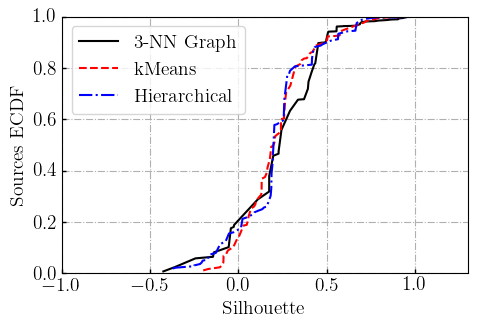

In [28]:
def sh_sources(plt, knn_ecdf, kmeans_ecdf, hierarchical_ecdf):
    plt.plot(knn_ecdf.sh, knn_ecdf.coverage, color='k', label='3-NN Graph')
    
    plt.plot(kmeans_ecdf.sh, kmeans_ecdf.coverage, color='r', label='kMeans')
    plt.plot(hierarchical_ecdf.sh, hierarchical_ecdf.coverage, color='b', label='Hierarchical')

    plt.xlabel('Silhouette')
    plt.ylabel('Sources ECDF')
    plt.legend()
    plt.grid(linestyle='-.')
    plt.xlim(-1, 1.3)

#plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: sh_sources(plt, knn_ecdf, kmeans_ecdf, spectral_ecdf, hierarchical_ecdf),
#                      figsize=(5, 3.5), fontsize=14, style='latex')
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: sh_sources(plt, knn_ecdf, kmeans_ecdf, 
                                                                                       hierarchical_ecdf),
                     figsize=(5, 3.5), fontsize=14, style='latex')
if not DEMONSTRATIVE:
    plot.savefig('reports/figures/sh_sources_clustering.pdf')
    pass
plot.show()

<Figure size 640x480 with 0 Axes>

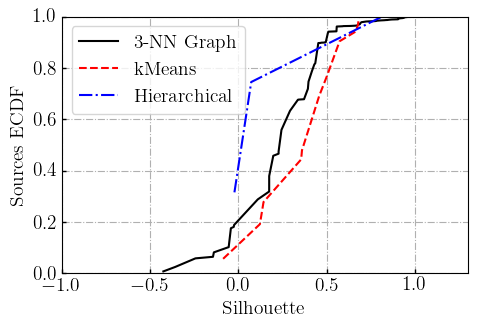

In [27]:
def sh_sources(plt, knn_ecdf, kmeans_ecdf, hierarchical_ecdf):
    plt.plot(knn_ecdf.sh, knn_ecdf.coverage, color='k', label='Louvain')
    
    plt.plot(kmeans_ecdf.sh, kmeans_ecdf.coverage, color='r', label='kMeans')
    plt.plot(hierarchical_ecdf.sh, hierarchical_ecdf.coverage, color='b', label='Hierarchical')

    plt.xlabel('Silhouette')
    plt.ylabel('Sources ECDF')
    plt.legend()
    plt.grid(linestyle='-.')
    plt.xlim(-1, 1.3)

#plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: sh_sources(plt, knn_ecdf, kmeans_ecdf, spectral_ecdf, hierarchical_ecdf),
#                      figsize=(5, 3.5), fontsize=14, style='latex')
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: sh_sources(plt, knn_ecdf, kmeans_ecdf0, 
                                                                                       hierarchical_ecdf0),
                     figsize=(5, 3.5), fontsize=14, style='latex')
#if not DEMONSTRATIVE:
#    plot.savefig('reports/figures/sh_sources_clustering_heur.pdf')
#plot.show()

In [5]:
import fastplot

def sh_sources(plt):
    plt.plot([], color='k', label='Louvain')
    
    plt.xlabel('Silhouette')
    plt.ylabel('Sources ECDF')
    plt.legend()
    plt.grid(linestyle='-.')
    plt.xlim(-1, 1.3)
    
%matplotlib inline
#plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: sh_sources(plt, knn_ecdf, kmeans_ecdf, spectral_ecdf, hierarchical_ecdf),
#                      figsize=(5, 3.5), fontsize=14, style='latex')
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: sh_sources(plt),
                     figsize=(5, 3.5), fontsize=14, style='latex')
#if not DEMONSTRATIVE:
plot.savefig('tmp.pdf')

In [41]:
sh_df = get_shs_df(knn, embeddings)
scatters = sh_df.reset_index().groupby('C').agg({'ip':'count', 'sh':'mean'})

In [50]:
scatters['ip_perc'] = 100*scatters.ip / scatters.sum().ip

ip         14.000000
sh          0.669226
ip_perc     0.062503
Name: 30, dtype: float64

<Figure size 640x480 with 0 Axes>

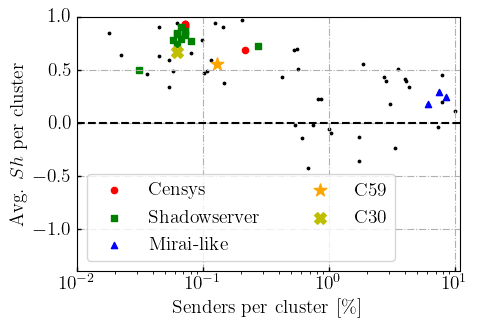

In [54]:
def scatterplot_sh(plt, scatters):
    censys = [7, 16, 20, 48, 52, 55, 60]
    shadowserver = [3, 10, 12, 32, 34, 50, 63, 64, 65, 66, 68, 69]
    mirai = [39, 45, 36]
    unknown = [59, 30]
    
    cm = plt.cm.get_cmap('cool')
    xy = np.arange(-1, 1, .1)
    plt.scatter(scatters.ip_perc, scatters.sh, s=8-5, color='k')
    temp = scatters.loc[censys]
    plt.scatter(temp.ip_perc, temp.sh, marker='o', s=30-10, alpha=1, color='r', label = 'Censys')
    temp = scatters.loc[shadowserver]
    plt.scatter(temp.ip_perc, temp.sh, marker='s', s=30-10, alpha=1, color='g', label= 'Shadowserver')
    temp = scatters.loc[mirai]
    plt.scatter(temp.ip_perc, temp.sh, marker='^', s=30-10, alpha=1, color='b', label= 'Mirai-like')
    temp = scatters.loc[[unknown[0]]]
    plt.scatter(temp.ip_perc, temp.sh, marker='*', s=100-10, alpha=1, color='orange', label='C59')
    temp = scatters.loc[[unknown[1]]]
    plt.scatter(temp.ip_perc, temp.sh, marker='X', s=80-10, alpha=1, color='y', label='C30')
    plt.legend(ncol=2)
    
    plt.xlabel('Senders per cluster [\%]')
    plt.ylabel('Avg. $Sh$ per cluster')
    plt.xscale('log')
    #plt.yscale('log')
    plt.hlines(0, 1e-2, 1e2, color='k', linestyle='--')
    plt.grid(linestyle='-.')
    plt.xlim(1e-2, 1.1e1)
    plt.ylim(-1.4)
    plt.yticks([-1, -.5, .0, .5, 1])

%matplotlib inline   
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: scatterplot_sh(plt, scatters),
                      figsize=(5, 3.5), fontsize=14, style='latex')
if not DEMONSTRATIVE:
    plot.savefig('reports/figures/silhouette_scatter.pdf')
plot.show()

In [55]:
sh_df = get_shs_df(knn, embeddings)
sh_df = sh_df.groupby('C').agg({'sh':'mean'})
sh_df = sh_df.reset_index().sort_values('sh', ascending=False)\
             .reset_index().drop(columns=['index'])

In [62]:
def shplot_(plt, sh_df):
    censys = [7, 16, 20, 48, 52, 55, 60]
    shadowserver = [3, 10, 12, 32, 34, 50, 63, 64, 65, 66, 68, 69]
    mirai = [39, 45, 36]
    unknown = [59, 30]
    plt.plot(sh_df.index, sh_df.sh, color='k')
    temp = sh_df[sh_df.C.isin(censys)]
    plt.scatter(temp.index, temp.sh, marker='o', s=30, alpha=1, color='r', label = 'Censys')
    temp = sh_df[sh_df.C.isin(shadowserver)]
    plt.scatter(temp.index, temp.sh, marker='s', s=30, alpha=1, color='g', label= 'Shadowserver')
    temp = sh_df[sh_df.C.isin(mirai)]
    plt.scatter(temp.index, temp.sh, marker='^', s=30, alpha=1, color='b', label= 'Mirai-like')
    temp = sh_df[sh_df.C.isin([unknown[0]])]
    plt.scatter(temp.index, temp.sh, marker='*', s=100, alpha=1, color='orange', label='C59')
    temp = sh_df[sh_df.C.isin([unknown[1]])]
    plt.scatter(temp.index, temp.sh, marker='X', s=80, alpha=1, color='y', label='C30')
    plt.legend(ncol=2)
    
    plt.xticks([0, 19, 39, 59], [1, 20, 40, 60])
    
    plt.hlines(0, 0, 70, linestyle='--', color='k')
    plt.xlabel('Cluster rank')
    plt.ylabel('Avg. Silhouette')
    plt.grid(linestyle='--')
    plt.ylim(-1.1, 1)
    plt.xlim(0,70)

<Figure size 640x480 with 0 Axes>

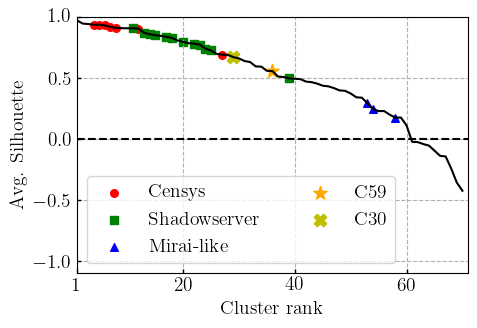

In [63]:
cmap = plt.cm.rainbow(np.linspace(0, 1, 5))

%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: shplot_(plt, sh_df),
                      figsize=(5, 3.5), fontsize=14, style='latex', cycler=cycler('color', cmap))
if not DEMONSTRATIVE:
    plot.savefig('reports/figures/sh_plot.pdf')
plot.show()

In [19]:
if not DEMONSTRATIVE:
    sh_df = get_shs_df(knn, embeddings)
    sh_df.to_csv(f'{DATASETS}/clusters.csv')

In [4]:
from sklearn.cluster import KMeans
import kneed

In [5]:
# Load last day of traffic
raw_data = load_raw_data('20210331')
filtered = filter_data(raw_data, '20210331')

print(filtered.shape)
filtered.head(3)

(3403919, 6)


,ts,ip,port,proto,pck_len,pp
ts,,,,,,
2021-03-30 22:29:08.691001,2021-03-30 22:29:08.691001,201.166.132.114,1433,tcp,66,1433/tcp
2021-03-30 22:29:08.691010,2021-03-30 22:29:08.691010,201.166.132.114,1433,tcp,66,1433/tcp
2021-03-30 22:29:08.811067,2021-03-30 22:29:08.811067,172.245.10.231,3699,tcp,60,3699/tcp


In [6]:
# Load the ground truth
gt = pd.read_csv(GT).drop(columns=['Unnamed: 0'])
ips = filtered.ip.unique()
# Get the lookup dataframe to retrieve
# the ground truth class of the last day senders
lookup = pd.DataFrame(ips, columns=['ip'])\
           .merge(gt, on='ip', how='left')\
           .fillna('unknown').replace({ 'criminalip':'unknown', 
                'adscore':'unknown', 'quadmetrics':'unknown', 
                'esrg_stanford':'unknown', 'netscout':'unknown'})

print(lookup.shape)
lookup.head(3)

(22399, 2)


,ip,class
0,201.166.132.114,unknown
1,172.245.10.231,unknown
2,119.237.180.88,unknown


In [7]:
model_path_name = f'word2vec_auto_c5_e200'
w2v = Word2Vec(mname=f'{MODELS}/word2vec/{model_path_name}')
w2v.load_model()
embeddings = w2v.get_embeddings(ips, lookup)

print(embeddings.shape)
embeddings.head(3)

(22399, 201)


,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,class
ip,,,,,,,,,,,,,,,,,,,,,
201.166.132.114,-0.311996,-0.151880,-0.126155,-0.072640,-0.178640,0.024080,-0.022133,0.057160,-0.323721,0.022568,...,0.283371,0.126785,0.275466,0.114976,0.073976,-0.138251,0.262670,-0.148449,-0.197116,unknown
172.245.10.231,-1.256613,-1.317889,-0.910986,-0.773604,-1.041731,0.157510,-0.035242,-0.574435,-0.953921,-0.234043,...,0.120722,0.061658,0.289806,0.052150,0.272534,0.037336,0.426259,-0.294904,0.005054,unknown
119.237.180.88,-0.090121,-0.085896,0.007295,-0.115396,-0.096167,0.018933,-0.014268,0.004455,-0.023784,0.002346,...,0.032283,0.021382,0.159330,0.020799,0.031832,-0.078330,0.073449,0.004153,-0.060807,unknown


In [8]:
# Compute distance matrix
from sklearn.metrics import pairwise_distances as distances
X = embeddings.drop(columns=['class']).to_numpy()
dist = distances(X, X, metric='cosine')

In [9]:
def elbow_eps(distance, nod, plot=False):
    """ elbow method on kdist plot for DBSCAN epsilon
    """
    from sklearn.neighbors import NearestNeighbors
    import kneed 

    k = int(np.log(nod.shape[0])-1)
    nn = NearestNeighbors(n_neighbors = k, metric='precomputed').fit(distance)
    ds, idx = nn.kneighbors()
    srtd = np.sort(-ds[:,-1])
    srtd = -srtd/nod.shape[1]
    kneedle = kneed.KneeLocator(
        range(srtd.shape[0]), srtd, curve="convex", direction="decreasing", S=1
    )
    
    if plot:
        %matplotlib inline
        plt.figure()
        plt.plot(srtd, color='k')
        plt.vlines(kneedle.knee, 0, np.max(srtd), color='r', linestyle='--')
        #plt.yscale('log')
        plt.ylim(0,  np.max(srtd))
        plt.grid()
        plt.xlabel('Observations')
        plt.ylabel('kNN distance')
        plt.tight_layout()
        plt.show()
        plt.close()
        
    return srtd[kneedle.knee]

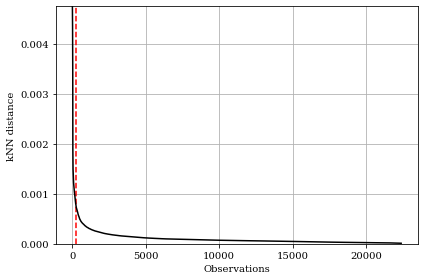

knee at epsilon = 0.0007183655816670998


In [10]:
eps = elbow_eps(dist, X, True)
print(f'knee at epsilon = {eps}')

In [11]:
from sklearn.cluster import DBSCAN

minPts = int(np.log(X.shape[0])-1)
dbscan = DBSCAN(eps=eps, 
                min_samples=minPts, 
                metric='precomputed', 
                n_jobs=-1)

pred1 = dbscan.fit_predict(dist)

In [12]:
set(pred1)

{-1}

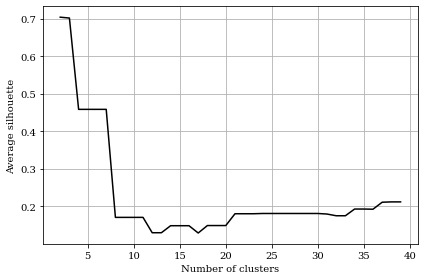

In [13]:
from sklearn.cluster import AgglomerativeClustering as HAC
from sklearn.metrics import silhouette_score as silhouette
shs = []
ncs = []
for k in range(2, 40):
    cl = HAC(n_clusters=k, affinity='precomputed', linkage='complete', compute_full_tree=True)
    pred3 = cl.fit_predict(dist)
    sh = silhouette(dist, pred3, metric='precomputed')
    
    shs.append(sh)
    ncs.append(k)
plt.figure()
plt.plot(ncs, shs, color='k')
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette')

plt.tight_layout()

In [14]:
ks = []
wss = []
for k in range(2, 40):
    kmeans = KMeans(n_clusters = k, random_state=20)
    pred = kmeans.fit_predict(X)
    ks.append(k)
    wss.append(kmeans.inertia_) 

kneedle = kneed.KneeLocator(
    ks, wss, curve="convex", direction="decreasing", S=10
)

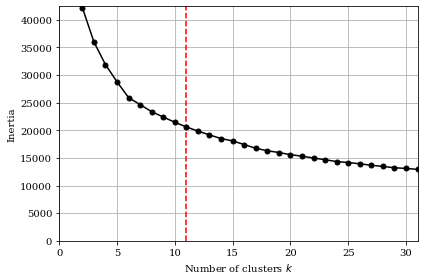

In [15]:
plt.figure()
plt.plot(ks, wss, color='k', marker='o', markersize=5)
plt.vlines(kneedle.knee, 0, np.max(wss)+1000, color='r', linestyle='--')
plt.grid()
plt.xlabel('Number of clusters $k$')
plt.ylabel('Inertia')
plt.ylim(0, np.max(wss)+200)
plt.xlim(0, 31)

plt.tight_layout()